# CVAE/FNN Modèle hybride - Workflow

## Imports et chargement des données

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import optuna
import seaborn as sns
import pandas as pd
from torch.distributions import MultivariateNormal
from CVAE.cvae import CVAEIntegrated
from torch.utils.data import DataLoader
from optuna.pruners import HyperbandPruner
from scipy.signal import find_peaks, filtfilt
from scipy.signal.windows import gaussian
from torch.utils.data import DataLoader
from utils.dataload import prepare_data_loaders, set_seed
from utils.functions import (
    load_model_cvae,
    cvae_latent_2d,
    cvae_latent_umap_static,
    cvae_reconstruction,
    display_spectrums,
    print_top_latent_std,
    hybrid_model_evaluation
)
print(torch.cuda.is_available())        
print(torch.cuda.get_device_name(0))    
set_seed(42) 

c:\Users\gabriel.legros\Desktop\C2N-inverse-design-app\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
NVIDIA T400 4GB


In [2]:
# Data loading and preparation
# ============================================================
dataloader_train, dataloader_test, dataset, train_dataset, test_dataset, scaler_x, scaler_z, dim_x, dim_y, input_dim, device = prepare_data_loaders(batch_size=256, test_ratio=0.2, plot_example=False, seed=42)
cond_dim = 2  # Dimensions du label [fréquence, n_eff]

Data loaded and normalized. Returning dataset.
Train dataset size: 8105
Test dataset size: 2026
X_batch shape: torch.Size([256, 4])
y_batch shape: torch.Size([256, 5000])
labels_batch shape: torch.Size([256, 2])
dim_x: 4
dim_y: 5000
Input dimension: 5004
Using device: cuda


In [ ]:
# CVAE loading
# ============================================================
cvae, scaler_x, scaler_z = load_model_cvae(device)

## Génération synthétique automatique

In [4]:
# Paramètres cibles et tolérances
# ============================================================
freq = 2e14  # Fréquence cible
n_eff = 1.8  # Indice effectif cible

f_tol = 1e11 # Hz
n_tol = 1e-3

In [5]:
# Hybrid model evaluation / saving=True to save the results in .csv file
# ============================================================
geometry, spectra, frequencies, indexes = hybrid_model_evaluation(cvae, dataloader_train, device, 
                                                                  freq, n_eff, tol_f=f_tol, tol_n=n_tol, n_samples=30000, 
                                                                  scaler_x=scaler_x, scaler_z=scaler_z, saving=True)       

Fichiers CSV exportés dans results/ : SWG_waveguide_geometry.csv, SWG_waveguide_spectra.csv, SWG_waveguide_labels.csv


----------------------------------------------

----------------------------------

## CVAE Modeling

### Optimisation Optuna

In [ ]:
def objective(trial):

    # Hyperparamètres à optimiser
    n_layers = trial.suggest_int("n_layers", 2, 5)
    latent_dim = trial.suggest_int("latent_dim", 5, 45, step=8)

    hidden_dim_list_encoder = []
    max_dim = 2048
    for i in range(n_layers):
        min_dim = 128
        # Pour le premier layer, max_dim=2048, pour les suivants, max_dim=précédent
        dim = trial.suggest_int(f"hidden_dim{i+1}", min_dim, max_dim, step=256)
        hidden_dim_list_encoder.append(dim)
        max_dim = dim  # borne supérieure pour le prochain layer

    hidden_dim_list_decoder = []
    min_dim = 128
    max_dim = 2048
    for i in range(n_layers):
        # Pour le premier layer, min_dim=128, pour les suivants, min_dim=précédent
        dim = trial.suggest_int(f"hidden_dim_dec{i+1}", min_dim, max_dim, step=256)
        hidden_dim_list_decoder.append(dim)
        min_dim = dim  # borne inférieure pour le prochain layer (croissant)
    
    n_layers_fnn = trial.suggest_int("n_layers_fnn", 4, 8)
    hidden_dim_list_fnn = []  
    for i in range(n_layers_fnn):
        hidden_dim_fnn = trial.suggest_int(f"hidden_dim_fnn{i+1}", 256, 2048, step=128)
        hidden_dim_list_fnn.append(hidden_dim_fnn)
    dropout_fnn = trial.suggest_float("dropout_fnn", 0.0, 0.3)

    dropout = trial.suggest_float("dropout", 0.0, 0.1)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    beta = trial.suggest_float("beta", 1e-5, 1e-1, log=True)
    #gamma = trial.suggest_float("gamma", 0.0001, 1, log=True)
    print(f"Hyperparameters: encoder={hidden_dim_list_encoder}, decoder={hidden_dim_list_decoder}, fnn={hidden_dim_list_fnn}, classifieur={None}, latent_dim={latent_dim}, dropout={dropout}, lr={lr}, beta={beta}, gamma={None}")

    # Modèle CVAE
    model = CVAEIntegrated(
        design_dim=dim_x,
        spectrum_dim=dim_y,
        cond_dim=cond_dim,
        latent_dim=latent_dim,
        hidden_dims_encoder=hidden_dim_list_encoder,  # list for encoder
        hidden_dims_decoder=hidden_dim_list_decoder,  # list for decoder
        hidden_dims_fnn=hidden_dim_list_fnn,  # list for FNN
        dropoutFNN=dropout_fnn,  # dropout for FNN
        hidden_dim_classifier=None,  # unused, but kept for compatibility
        dropoutCVAE=dropout,
        beta=beta,
        gamma=None
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    num_epochs = 100
    for epoch in range(num_epochs):

        model.train()
        epoch_loss = 0
        for A, B, C in dataloader_train:
            A, B, C = A.to(device), B.to(device), C.to(device)
            optimizer.zero_grad()
            A_hat, B_pred, mu, logvar, C_pred = model(A, B, C)
            loss, _, _, _ = model.loss(A_hat, A, B_pred, B, mu, logvar, C, C_pred)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(dataloader_train)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for A, B, C in dataloader_test:
                A, B, C = A.to(device), B.to(device), C.to(device)
                A_hat, B_pred, mu, logvar, C_pred = model(A, B, C)
                loss, loss_rec, loss_pred, kl = model.loss(A_hat, A, B_pred, B, mu, logvar, C, C_pred)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(dataloader_test)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training : {avg_train_loss:.4f} ---- Validation : {avg_val_loss:.4f} ---- Rec: {loss_rec:.4f}, Pred: {loss_pred:.4f}, KL: {kl:.4f}")
        
        # Avant de reporter à Optuna
        if np.isnan(avg_val_loss) or np.isinf(avg_val_loss):
            raise optuna.TrialPruned()  # prune immédiatement si NaN ou inf

        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return avg_val_loss

pruner = HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=4)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.enqueue_trial({
    "n_layers": 2,
    "latent_dim": 29,
    "hidden_dim1": 1920,
    "hidden_dim2": 1664,
    "hidden_dim_dec1": 1664,
    "hidden_dim_dec2": 1920,
    "n_layers_fnn": 4,
    "hidden_dim_fnn1": 1408,
    "hidden_dim_fnn2": 1536,
    "hidden_dim_fnn3": 768,
    "hidden_dim_fnn4": 768,
    "dropout_fnn": 0.2492675360232907,
    "dropout": 2.5594012345469576e-05,
    "lr": 0.0004027310397716686,
    "beta": 2.475508242958973e-05
})
study.optimize(objective, n_trials=5)

print("Meilleurs hyperparamètres :", study.best_params)
print("Meilleure loss de validation :", study.best_value)

### Training CVAE

In [6]:
best_params = study.best_params
print("Meilleurs hyperparamètres trouvés :")
for key, value in best_params.items():
    print(f"{key}: {value}")

Meilleurs hyperparamètres trouvés :
n_layers: 2
latent_dim: 29
hidden_dim1: 1920
hidden_dim2: 1664
hidden_dim_dec1: 1664
hidden_dim_dec2: 1920
n_layers_fnn: 4
hidden_dim_fnn1: 1408
hidden_dim_fnn2: 1536
hidden_dim_fnn3: 768
hidden_dim_fnn4: 768
dropout_fnn: 0.2492675360232907
dropout: 2.5594012345469576e-05
lr: 0.0004027310397716686
beta: 2.475508242958973e-05


In [9]:
latent_dim = best_params["latent_dim"]
n_layers = best_params["n_layers"]
hidden_dim_list_encoder = [best_params[f"hidden_dim{i+1}"] for i in range(n_layers)]
hidden_dim_list_decoder = [best_params[f"hidden_dim_dec{i+1}"] for i in range(n_layers)]
hidden_dim_list_fnn = [best_params[f"hidden_dim_fnn{i+1}"] for i in range(best_params["n_layers_fnn"])]
dropout_fnn = best_params["dropout_fnn"]

hidden_dim_list_classifieur = None
dropout = best_params["dropout"]
lr = best_params["lr"]
beta = best_params["beta"]
gamma = None

In [ ]:
# Entraînement final avec les meilleurs hyperparamètres
    # Modèle CVAE
cvae = CVAEIntegrated(
    design_dim=dim_x,
    spectrum_dim=dim_y,
    cond_dim=cond_dim,
    latent_dim=latent_dim,
    hidden_dims_encoder=hidden_dim_list_encoder,  # list for encoder
    hidden_dims_decoder=hidden_dim_list_decoder,  # list for decoder
    hidden_dims_fnn=hidden_dim_list_fnn,  # list for FNN
    dropoutFNN=dropout_fnn,  # dropout for FNN
    hidden_dim_classifier=hidden_dim_list_classifieur,  # unused, but kept for compatibility
    dropoutCVAE=dropout,
    beta=beta,
    gamma=gamma
).to(device)

optimizer = torch.optim.Adam(cvae.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-6)

num_epochs = 600

for epoch in range(num_epochs):

    cvae.train()
    epoch_loss = 0
    for A, B, C in dataloader_train:
        A, B, C = A.to(device), B.to(device), C.to(device)
        optimizer.zero_grad()
        A_hat, B_pred, mu, logvar, C_pred = cvae(A, B, C)
        loss, _, _, _ = cvae.loss(A_hat, A, B_pred, B, mu, logvar, C, C_pred)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(dataloader_train)

    # Validation
    cvae.eval()
    val_loss = 0
    with torch.no_grad():
        for A, B, C in dataloader_test:
            A, B, C = A.to(device), B.to(device), C.to(device)
            A_hat, B_pred, mu, logvar, C_pred = cvae(A, B, C)
            loss, loss_rec, loss_pred, kl = cvae.loss(A_hat, A, B_pred, B, mu, logvar, C, C_pred)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(dataloader_test)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training : {avg_train_loss:.4f} ---- Validation : {avg_val_loss:.4f} ---- Rec: {loss_rec:.4f}, Pred: {loss_pred:.4f}, KL: {kl:.4f}")
    

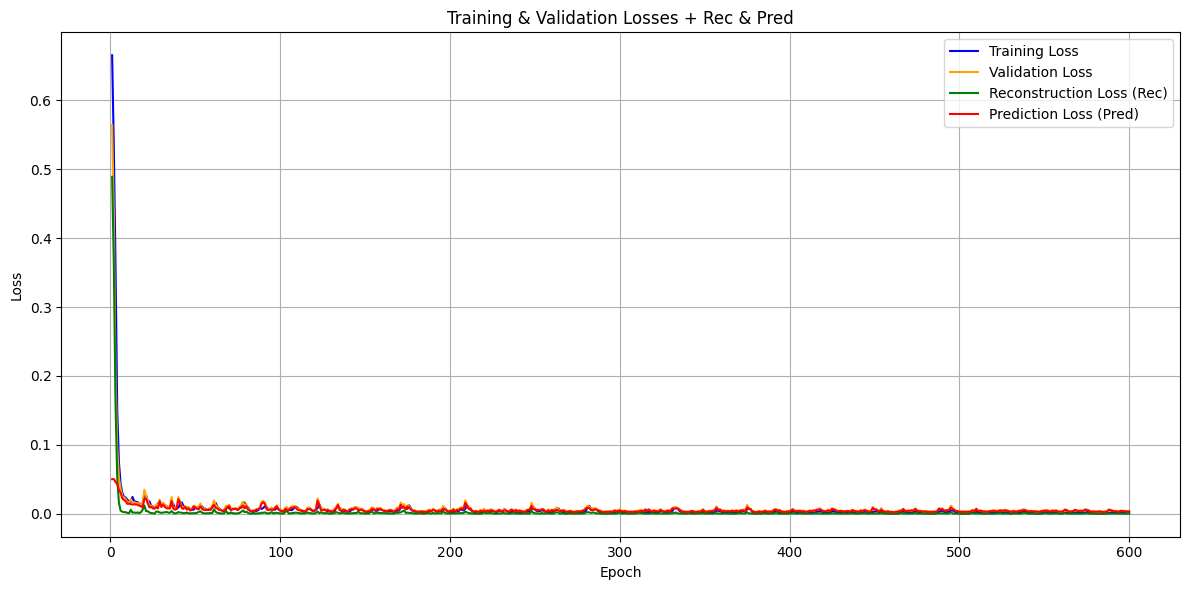

### Sauvegarde du modèle

In [37]:
# Sauvegarde du modèle CVAE entraîné
checkpoint = {
    "model_state_dict": cvae.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "latent_dim": latent_dim,
    "hidden_dims_encoder": hidden_dim_list_encoder,
    "hidden_dims_decoder": hidden_dim_list_decoder,
    "hidden_dim_classifier": hidden_dim_list_classifieur,
    "gamma": gamma,
    "dropout": dropout,
    "beta": beta,
    "lr": lr,
    "input_dim": dim_x,
    "output_dim": dim_y,
    "cond_dim": cond_dim,
    "scaler_x": scaler_x,
    "scaler_z": scaler_z
}
torch.save(checkpoint, "saved_models/cvae_trained_classifieur.pth")

## Chargement du modèle CVAE

In [ ]:
checkpoint = torch.load("saved_models/cvae_trained_2.pth", map_location="cpu")

cvae = CVAEIntegrated(
    design_dim=checkpoint["input_dim"],
    spectrum_dim=checkpoint["output_dim"],
    cond_dim=checkpoint["cond_dim"],
    latent_dim=checkpoint["latent_dim"],
    hidden_dims_encoder=checkpoint["hidden_dims_encoder"],
    hidden_dims_decoder=checkpoint["hidden_dims_decoder"],
    hidden_dims_fnn=None,
    dropoutFNN=None,
    hidden_dim_classifier=None,  
    gamma=None, 
    dropoutCVAE=checkpoint["dropout"],
    beta=checkpoint["beta"]
).to(device)
cvae.load_state_dict(checkpoint["model_state_dict"])
cvae.eval()

optimizer = torch.optim.Adam(cvae.parameters(), lr=checkpoint["lr"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

scaler_x = checkpoint["scaler_x"]
scaler_z = checkpoint["scaler_z"]

print("Latent dimension :", checkpoint["latent_dim"])
print("Hidden dimensions encoder :", checkpoint["hidden_dims_encoder"])
print("Hidden dimensions decoder :", checkpoint["hidden_dims_decoder"])
print("Dropout :", checkpoint["dropout"])
print("Beta :", checkpoint["beta"])
print("Learning rate :", checkpoint["lr"])

print("Modèle CVAE chargé avec succès.")

### Test de reconstruction

In [ ]:
# Reconstruction des données de test
# ============================================================
A, B, C, A_hat, B_pred = cvae_reconstruction(cvae, dataloader_test, device)

# Inverse de la standardisation
if hasattr(A_hat, "cpu"):
    recon_x_orig = scaler_x.inverse_transform(A_hat.cpu().numpy())
else:
    recon_x_orig = scaler_x.inverse_transform(A_hat)

if hasattr(A, "cpu"):
    orig_x_orig = scaler_x.inverse_transform(A.cpu().numpy())
else:
    orig_x_orig = scaler_x.inverse_transform(A)

index = 0
print("=== Données originales ===")
print("X:", orig_x_orig[index])
print("\n=== Reconstruction ===")
print("X reconstruit:", recon_x_orig[index])

n_examples = 5
display_spectrums(n_examples, B, B_pred)

### Analyse de l'espace latent

In [6]:
# Visualisation des composantes latentes actives
# ============================================================
dataloader_train_big = DataLoader(train_dataset, batch_size=1024, shuffle=False)
z_list = []
cvae.eval()
with torch.no_grad():
    for A,B,C in dataloader_train:
        A, B, C = A.to(device), B.to(device), C.to(device)
        mu, logvar = cvae.encode(A,B,C)
        z_list.append(mu.cpu())  # stocke les mu (sans reparam.)
# Concatène tous les z en un seul tensor
z_train = torch.cat(z_list, dim=0)  # shape [N, latent_dim]

print("Shape of z_train:", z_train.shape)
std = z_train.std(dim=0)
top3_indices = print_top_latent_std(std, top_n=3)
index1, index2 = top3_indices[0], top3_indices[1]

Shape of z_train: torch.Size([8105, 10])
Std of z_train (sorted):
z[3] : 0.7554
z[7] : 0.5772
z[6] : 0.5593
z[0] : 0.4705
z[9] : 0.4140
z[4] : 0.3934
z[2] : 0.3660
z[8] : 0.3374
z[5] : 0.1794
z[1] : 0.0997

Indices des 3 plus grandes std : [3 7 6]


c:\Users\gabriel.legros\Desktop\C2N-inverse-design-app\CVAE-FNN V1\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gabriel.legros\Desktop\C2N-inverse-design-app\CVAE-FNN V1\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


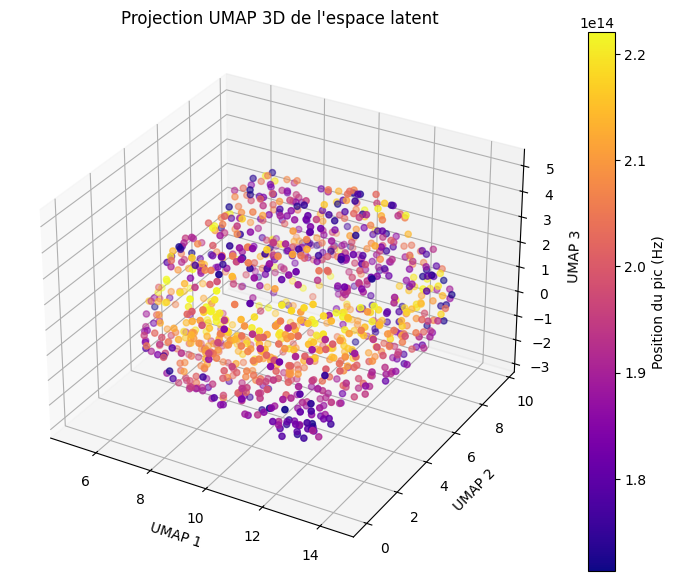

In [7]:
cvae_latent_umap_static(
    cvae, dataloader_train_big, scaler_z, color_mode="peak_pos", device=None, 
    n_neighbors=200, min_dist=0.9, metric="cosine", streamlit_show=False)

c:\Users\gabriel.legros\Documents\VSCode\Github\C2N\CVAE_FNN_Integrated\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gabriel.legros\Documents\VSCode\Github\C2N\CVAE_FNN_Integrated\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


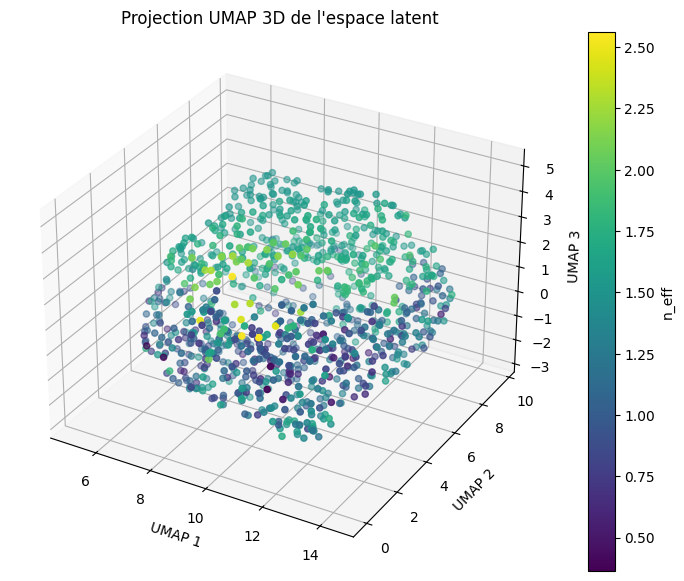

In [ ]:
cvae_latent_umap_static(
    cvae, dataloader_train_big, scaler_z, color_mode="label_n", device=None, 
    n_neighbors=200, min_dist=0.9, metric="cosine",streamlit_show=False)

A_batch shape: torch.Size([1024, 4])
B_batch shape: torch.Size([1024, 5000])
C_batch shape: torch.Size([1024, 2])


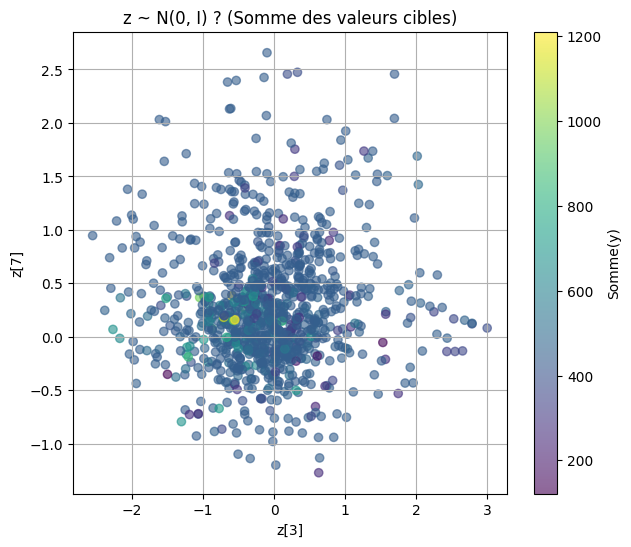

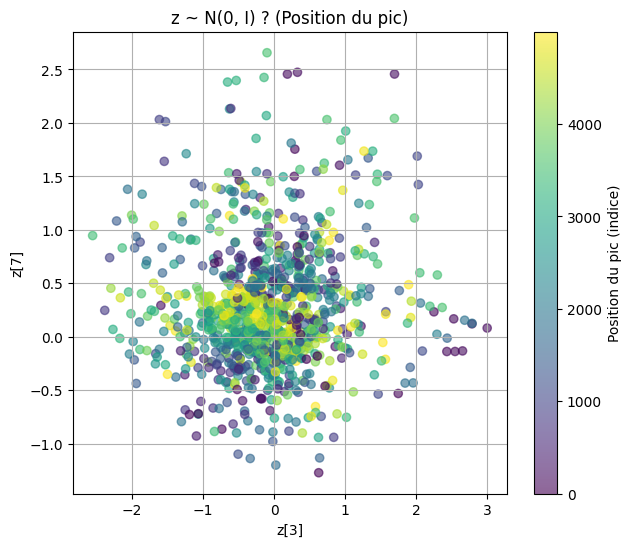

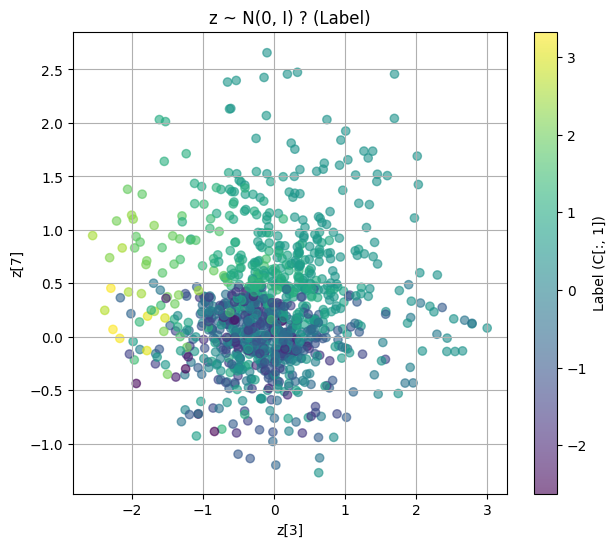

Variance moyenne de z : 0.21183572709560394
Moyenne de z : [-0.2608426   0.06128315  0.10357428 -0.08836649 -0.22396222  0.07942329
 -0.13777226  0.26497144  0.3004252   0.07072334]


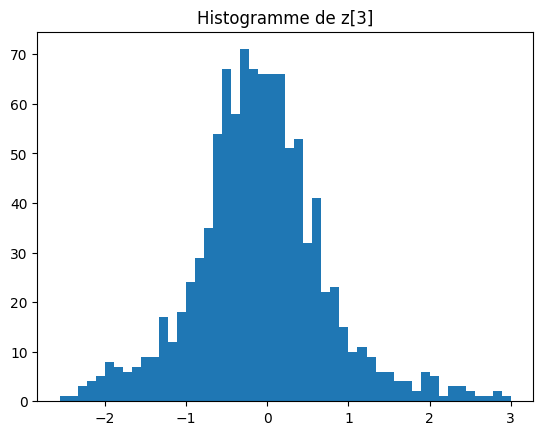

In [8]:
# Visualisation 2D des données dans l'espace latent
# ============================================================
cvae_latent_2d(cvae, dataloader_train_big, index_x=index1, index_y=index2, index_histo=index1, device=None, label_col=1)

### Modélisation du latent

In [ ]:
# Extraction des vecteurs latents (mu) pour modéliser la distribution latente (préparation à la génération synthétique)
# ============================================================
z_list = []
cvae.eval()
with torch.no_grad():
    for A,B,C in dataloader_train:
        A, B, C = A.to(device), B.to(device), C.to(device)
        mu, logvar = cvae.encode(A,B,C)
        z_list.append(mu.cpu())  # stocke les mu (sans reparam.)
# Concatène tous les z en un seul tensor
z_train = torch.cat(z_list, dim=0)  # shape [N, latent_dim]
print("Shape of z_train:", z_train.shape)

In [ ]:
# Modélisation de la distribution latente (calcul de la moyenne et de la covariance)
mean = z_train.mean(dim=0)  # centre
std = z_train.std(dim=0)    # écart-type par dimension
print("Mean of z_train:", mean)
print("Std of z_train:", std) 
  
# Matrice de covariance
cov = torch.cov(z_train.T)  # shape (latent_dim, latent_dim)
mean = mean.to(device)
std = std.to(device)
cov = cov.to(device)

## Génération synthétique manuelle

### Génération et prédiction

In [11]:
# Conditionnement sur les labels
# ============================================================
f_desired = 2e14
n_desired = 1.8
n_samples = 20000  # Nombre d'échantillons à générer

In [ ]:
# Génération et filtrage par densité de probabilité
# ============================================================
label_value = [f_desired, n_desired]  # le label que tu veux générer
label_value_scaled = scaler_z.transform(np.array([label_value]))
label_value_scaled = torch.tensor(label_value_scaled, dtype=torch.float32).to(device)

mvn = MultivariateNormal(mean, covariance_matrix=cov)

z = mvn.sample((n_samples,)).to(device)

# Filtrage des z trop improbables (garde les 99% les plus probables)
log_probs = mvn.log_prob(z)
threshold = torch.quantile(log_probs, 0.01)  # Garde les 99% les plus probables
mask = log_probs > threshold
z_filtered = z[mask]

label_tensor = label_value_scaled.expand(z_filtered.shape[0], -1)

print(f"Nombre de z gardés après filtrage : {z_filtered.shape[0]} sur {n_samples} échantillons")

# Générer les données avec le décodeur à partir des z filtrés
with torch.no_grad():
    A_hat_gen, B_pred_gen = cvae.decode(z_filtered, label_tensor)  # [n_samples_filtrés, input_dim]

# Dénormaliser si besoin
A_hat_gen_denorm = scaler_x.inverse_transform(A_hat_gen.cpu().numpy())

print("Shape X généré :", A_hat_gen_denorm.shape)
print("Shape Y généré :", B_pred_gen.shape)
print("Shape de label :", label_tensor.shape)

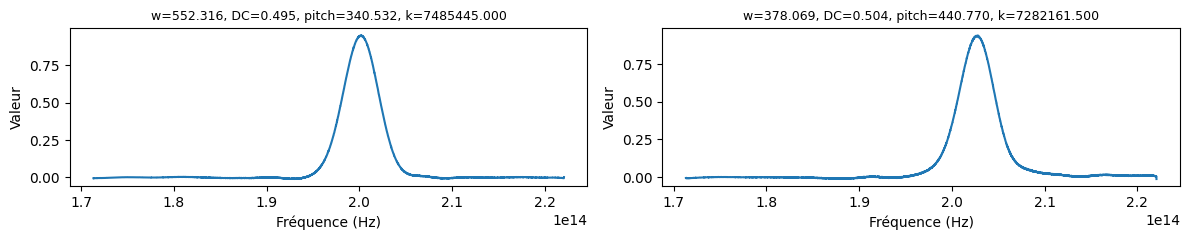

In [13]:
# Visualisation des spectres générés
# ============================================================
frequencies = np.linspace(171309976000000, 222068487407407, 5000)

# Sélectionne des indices aléatoires dans les données générées
n_plot = 2
indices = np.random.choice(B_pred_gen.shape[0], n_plot, replace=False)
n_cols = 2
n_rows = n_plot // n_cols

plt.figure(figsize=(12, 2.5 * n_rows))
for idx, i in enumerate(indices):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.plot(frequencies, B_pred_gen[i].cpu().numpy(), label='Spectre généré')
    w, DC, pitch, k = A_hat_gen_denorm[i, 0], A_hat_gen_denorm[i, 1], A_hat_gen_denorm[i, 2], A_hat_gen_denorm[i, 3]
    plt.title(f"w={w:.3f}, DC={DC:.3f}, pitch={pitch:.3f}, k={k:.3f}", fontsize=9)
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Valeur")
    plt.tight_layout()
plt.show()

### Filtrage des pics abbérants + calcul n_eff

In [14]:
# Analyse des pics dans les spectres générés
# ============================================================
# Paramètres du filtre et des pics
window = gaussian(M=21, std=5)
window /= window.sum()
frequencies = np.linspace(171309976000000, 222068487407407, 5000)
c = 299792458  # vitesse de la lumière

# Listes pour stocker les résultats
x_1pic, y_1pic, pred_1pic, f_1pic, n_eff_1pic = [], [], [], [], []

# Boucle sur tous les spectres générés
for i in range(len(B_pred_gen)):
    y = B_pred_gen[i].cpu().numpy()  # Convertit le spectre en numpy array
    y_smooth = filtfilt(window, [1], y)
    peaks, _ = find_peaks(y_smooth, height=0.1, prominence=0.05, distance=10)
    n_peaks = len(peaks)
    x = A_hat_gen_denorm[i]

    if n_peaks == 1:
        idx_max = np.argmax(y)
        f = frequencies[idx_max]
        n_eff = (c * x[3]) / (2 * np.pi * f)

        x_1pic.append(x)
        y_1pic.append(y)
        f_1pic.append(f)
        n_eff_1pic.append(n_eff)


print("Shape x_1pic:", np.array(x_1pic).shape)
print(f"Pourcentage de spectres à 1 pic : {len(x_1pic) / (len(x_1pic) + len(B_pred_gen)) * 100:.1f}%")

Shape x_1pic: (14129, 4)
Pourcentage de spectres à 1 pic : 41.6%


In [ ]:
# Affichage des résultats
# ============================================================
# Affichage de 3 spectres à 1 pic
n_1pic = min(3, len(y_1pic))
if n_1pic > 0:
    indices_1pic = np.random.choice(len(y_1pic), n_1pic, replace=False)
    plt.figure(figsize=(12, 2.5 * n_1pic))
    for idx, i in enumerate(indices_1pic):
        plt.subplot(n_1pic, 1, idx + 1)
        plt.plot(frequencies, y_1pic[i], label='Spectre 1 pic')
        w, DC, pitch, k = x_1pic[i][0], x_1pic[i][1], x_1pic[i][2], x_1pic[i][3]
        plt.title(f"1 pic | w={w:.3f}, DC={DC:.3f}, pitch={pitch:.3f}, k={k:.3f}", fontsize=9)
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Valeur")
        plt.legend()
        plt.tight_layout()
    plt.show()
else:
    print("Aucun spectre à 1 pic à afficher.")

### Statistiques sur f_max et n_eff

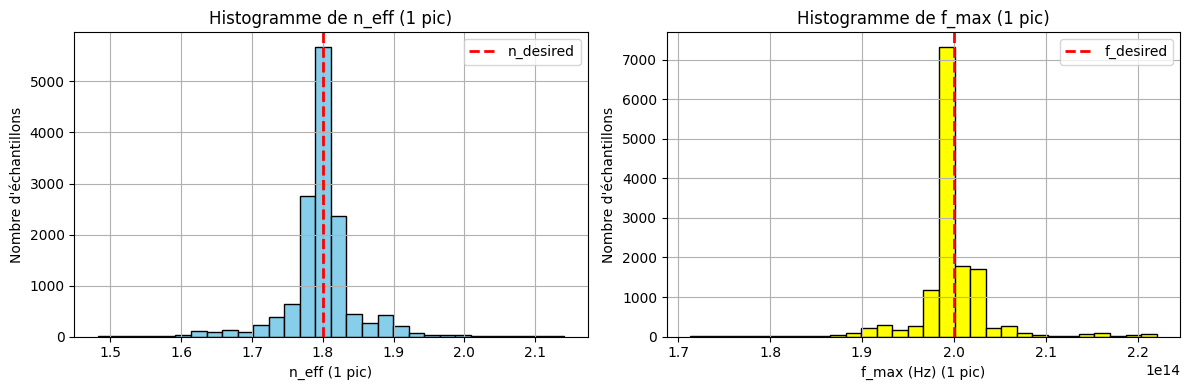

In [16]:
# Histogramme pour les spectres à 1 pic
if len(n_eff_1pic) > 0 and len(f_1pic) > 0:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(n_eff_1pic, bins=30, color='skyblue', edgecolor='k')
    plt.axvline(n_desired, color='red', linestyle='--', linewidth=2, label='n_desired')
    plt.xlabel("n_eff (1 pic)")
    plt.ylabel("Nombre d'échantillons")
    plt.title("Histogramme de n_eff (1 pic)")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(f_1pic, bins=30, color='yellow', edgecolor='k')
    plt.axvline(f_desired, color='red', linestyle='--', linewidth=2, label='f_desired')
    plt.xlabel("f_max (Hz) (1 pic)")
    plt.ylabel("Nombre d'échantillons")
    plt.title("Histogramme de f_max (1 pic)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Pas de spectres à 1 pic pour histogramme.")

### Filtrage par tolérance sur n_eff

In [17]:
n_tol = 1e-3

In [18]:
# Convertir en arrays numpy si ce n'est pas déjà fait
x_1pic = np.array(x_1pic)
y_1pic = np.array(y_1pic)
pred_1pic = np.array(pred_1pic)
f_1pic = np.array(f_1pic)
n_eff_1pic = np.array(n_eff_1pic)

# Masque de tolérance
mask_1pic = (np.abs(n_eff_1pic - n_desired) <= n_tol)

x_1pic_filt = x_1pic[mask_1pic]
y_1pic_filt = y_1pic[mask_1pic]
f_1pic_filt = f_1pic[mask_1pic]
n_eff_1pic_filt = n_eff_1pic[mask_1pic]

print(f"Spectres à 1 pic filtrés : {len(x_1pic_filt)}")

Spectres à 1 pic filtrés : 494


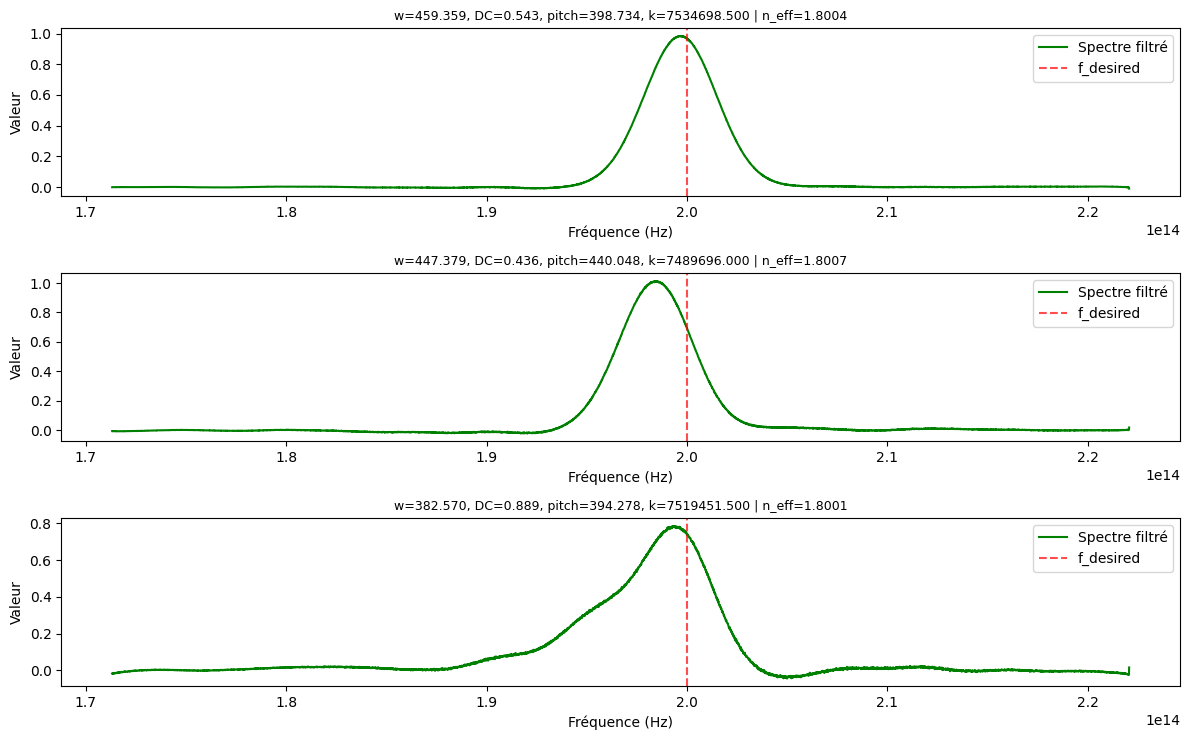

In [19]:
# Affichage aléatoire de 10 spectres à 1 pic filtrés
n_plot = min(3, x_1pic_filt.shape[0])
if n_plot > 0:
    indices = np.random.choice(x_1pic_filt.shape[0], n_plot, replace=False)
    frequencies = np.linspace(171309976000000, 222068487407407, y_1pic_filt.shape[1])

    plt.figure(figsize=(12, 2.5 * n_plot))
    for idx, i in enumerate(indices):
        plt.subplot(n_plot, 1, idx + 1)
        plt.plot(frequencies, y_1pic_filt[i], label='Spectre filtré', color='green')
        w, DC, pitch, k = x_1pic_filt[i][0], x_1pic_filt[i][1], x_1pic_filt[i][2], x_1pic_filt[i][3]
        n_eff = n_eff_1pic_filt[i]
        plt.axvline(f_desired, color='red', linestyle='--', alpha=0.7, label='f_desired')
        plt.title(f"w={w:.3f}, DC={DC:.3f}, pitch={pitch:.3f}, k={k:.3f} | n_eff={n_eff:.4f}", fontsize=9)
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Valeur")
        plt.legend()
        plt.tight_layout()
    plt.show()
else:
    print("Aucun spectre filtré à 1 pic à afficher.")

### Filtrage par tolérance sur f_max

In [21]:
f_tol = 1e11    # Hz

In [22]:
# Récupération de la fréquence du pic pour chaque spectre prédit dans y_pred1
f_max_pred = np.zeros(y_1pic_filt.shape[0])

for i in range(y_1pic_filt.shape[0]):
    idx_max = np.argmax(y_1pic_filt[i])
    f_max_pred[i] = frequencies[idx_max]

# Masque de tolérance
mask_1pic_2 = (np.abs(f_max_pred - f_desired) <= f_tol)

x_1pic_filt_2 = x_1pic_filt[mask_1pic_2]
y_1pic_filt_2 = y_1pic_filt[mask_1pic_2]
f_1pic_filt_2 = f_max_pred[mask_1pic_2]
n_eff_1pic_filt_2 = n_eff_1pic_filt[mask_1pic_2]

print(f"Spectres à 1 pic filtrés : {len(x_1pic_filt_2)}")

Spectres à 1 pic filtrés : 56


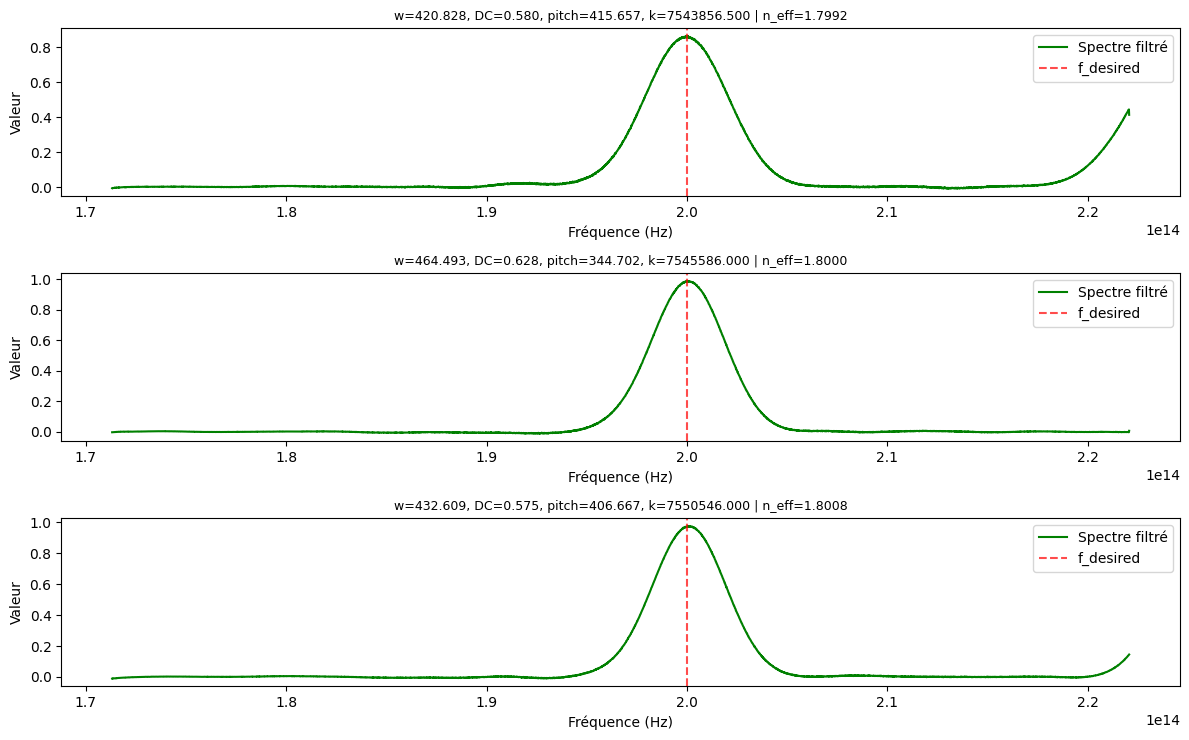

In [24]:
# Affichage aléatoire de 10 spectres à 1 pic filtrés
n_plot = min(3, x_1pic_filt_2.shape[0])
#x_1pic_filt_2 = scaler_x.inverse_transform(x_1pic_filt_2)  # Inverse de la standardisation
if n_plot > 0:
    indices = np.random.choice(x_1pic_filt_2.shape[0], n_plot, replace=False)

    plt.figure(figsize=(12, 2.5 * n_plot))
    for idx, i in enumerate(indices):
        plt.subplot(n_plot, 1, idx + 1)
        plt.plot(frequencies, y_1pic_filt_2[i],color='green', label='Spectre filtré')
        w, DC, pitch, k = x_1pic_filt_2[i][0], x_1pic_filt_2[i][1], x_1pic_filt_2[i][2], x_1pic_filt_2[i][3]
        n_eff = n_eff_1pic_filt_2[i]
        plt.axvline(f_desired, color='red', linestyle='--', alpha=0.7, label='f_desired')
        plt.title(f"w={w:.3f}, DC={DC:.3f}, pitch={pitch:.3f}, k={k:.3f} | n_eff={n_eff:.4f}", fontsize=9)
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Valeur")
        plt.legend()
        plt.tight_layout()
    plt.show()
else:
    print("Aucun spectre filtré à 1 pic à afficher.")

### Contraintes de fabrication

In [25]:
# Calcul du mask pour filtrer selon result1 >= 50 nm et result2 >= 50 nm
result1 = (1 - x_1pic_filt_2[:, 1]) * x_1pic_filt_2[:, 2]
result2 = x_1pic_filt_2[:, 1] * x_1pic_filt_2[:, 2]
mask_fab = (result1 >= 50) & (result2 >= 50)

# Application du mask
x_1pic_filt_3 = x_1pic_filt_2[mask_fab]
y_1pic_filt_3 = y_1pic_filt_2[mask_fab]
f_1pic_filt_3 = f_1pic_filt_2[mask_fab]
n_eff_1pic_filt_3 = n_eff_1pic_filt_2[mask_fab]

print(f"Nombre de samples après filtrage : {len(x_1pic_filt_3)}")

Nombre de samples après filtrage : 55


### Statistiques candidats retenus

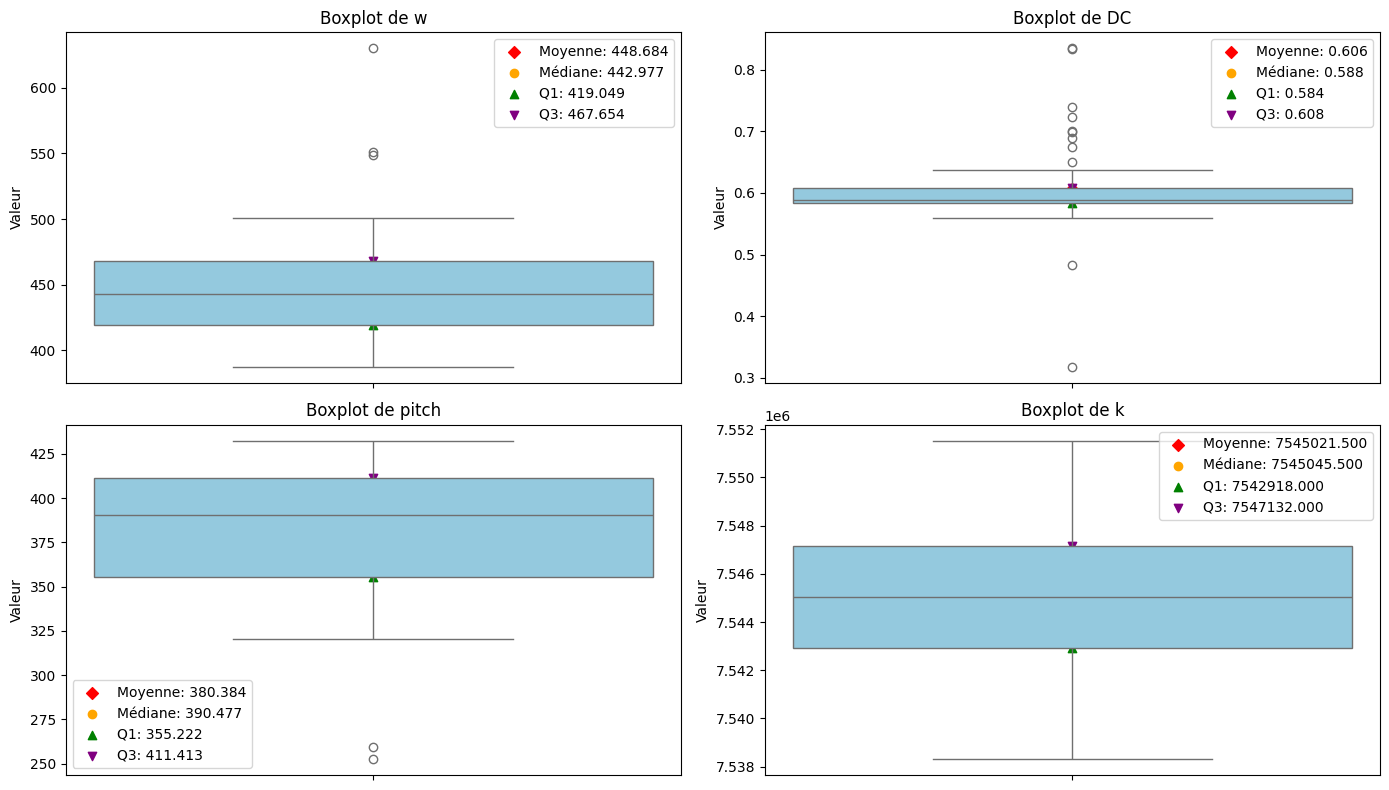

In [26]:
# Boxplots séparés pour chaque paramètre w, DC, pitch, k avec valeurs caractéristiques
# ============================================================
params = {
    "w": x_1pic_filt_3[:, 0],
    "DC": x_1pic_filt_3[:, 1],
    "pitch": x_1pic_filt_3[:, 2],
    "k": x_1pic_filt_3[:, 3],
}

plt.figure(figsize=(14, 8))
for i, (name, values) in enumerate(params.items(), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=values, color="skyblue", width=0.4)
    median = np.median(values)
    mean = np.mean(values)
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    plt.scatter(0, mean, color='red', marker='D', label=f'Moyenne: {mean:.3f}')
    plt.scatter(0, median, color='orange', marker='o', label=f'Médiane: {median:.3f}')
    plt.scatter(0, q1, color='green', marker='^', label=f'Q1: {q1:.3f}')
    plt.scatter(0, q3, color='purple', marker='v', label=f'Q3: {q3:.3f}')
    plt.title(f"Boxplot de {name}")
    plt.ylabel("Valeur")
    plt.legend(loc="best")

plt.tight_layout()

--------------------------------------------

--------------------------------------------------------------

## Vérification expérimentale

### Chargement des données FDTD

In [12]:
x_fdtd = np.load("fdtd/x_data.npy")
y_fdtd = np.load("fdtd/y_data.npy")

print("x_data shape:", x_fdtd.shape)
print("y_data shape:", y_fdtd.shape)

x_data shape: (562, 4)
y_data shape: (562, 5000)


### Filtrage spectres 1 pic + calcul n_eff

In [16]:
# Paramètres du filtre et des pics
window = gaussian(M=21, std=5)
window /= window.sum()
frequencies = np.linspace(171309976000000, 222068487407407, 5000)
c = 299792458  # vitesse de la lumière

# Listes pour stocker les résultats
x_1pic, y_1pic, pred_1pic, f_1pic, n_eff_1pic = [], [], [], [], []

# Boucle sur tous les spectres générés
for i in range(len(y_fdtd)):
    y = y_fdtd[i] # Convertit le spectre en numpy array
    y_smooth = filtfilt(window, [1], y)
    peaks, _ = find_peaks(y_smooth, height=0.1, prominence=0.05, distance=10)
    n_peaks = len(peaks)
    x = x_fdtd[i]

    if n_peaks == 1:
        idx_max = np.argmax(y)
        f = frequencies[idx_max]
        n_eff = (c * x[3]) / (2 * np.pi * f)

        x_1pic.append(x)
        y_1pic.append(y)
        f_1pic.append(f)
        n_eff_1pic.append(n_eff)
print("Shape x_1pic:", np.array(x_1pic).shape)

Shape x_1pic: (358, 4)


### Affichage des spectres

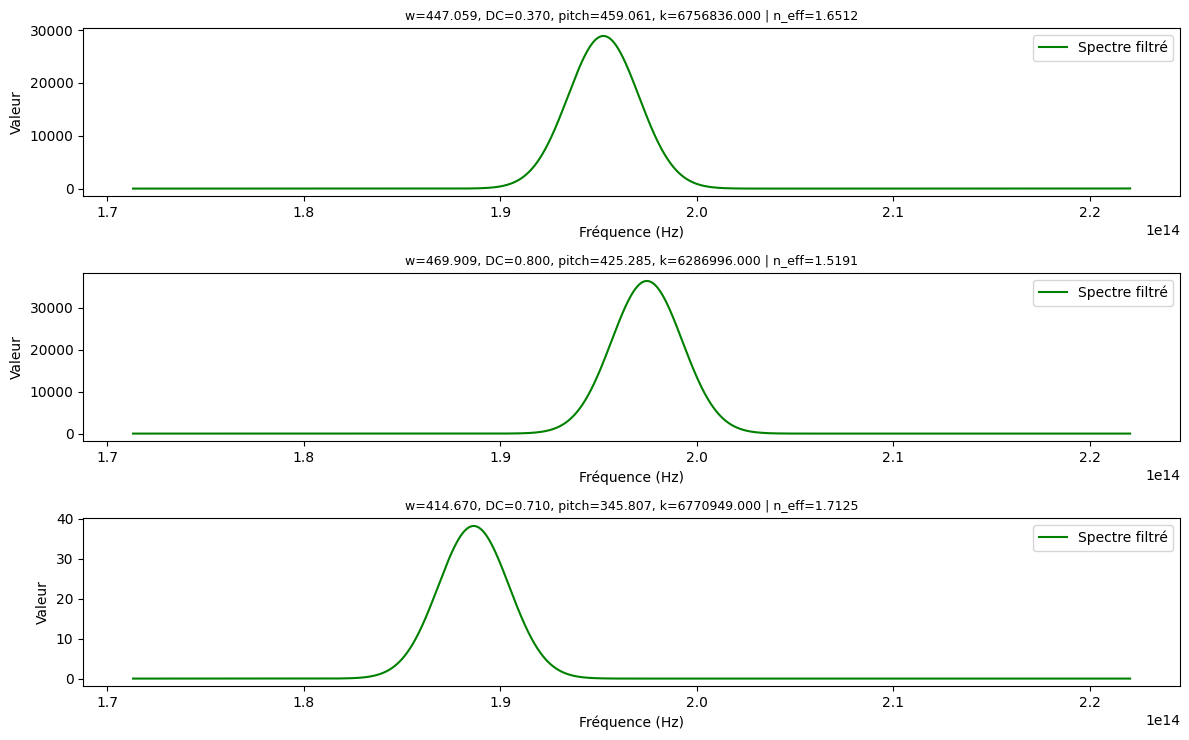

In [18]:
# Affichage aléatoire de 10 spectres à 1 pic filtrés
n_plot = min(3, len(x_1pic))
#x_1pic_filt_2 = scaler_x.inverse_transform(x_1pic_filt_2)  # Inverse de la standardisation
if n_plot > 0:
    indices = np.random.choice(len(x_1pic), n_plot, replace=False)

    plt.figure(figsize=(12, 2.5 * n_plot))
    for idx, i in enumerate(indices):
        plt.subplot(n_plot, 1, idx + 1)
        plt.plot(frequencies, y_1pic[i],color='green', label='Spectre filtré')
        w, DC, pitch, k = x_1pic[i][0], x_1pic[i][1], x_1pic[i][2], x_1pic[i][3]
        n_eff = n_eff_1pic[i]
        plt.title(f"w={w:.3f}, DC={DC:.3f}, pitch={pitch:.3f}, k={k:.3f} | n_eff={n_eff:.4f}", fontsize=9)
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Valeur")
        plt.legend()
        plt.tight_layout()
    plt.show()
else:
    print("Aucun spectre filtré à 1 pic à afficher.")

### Résultats labels

C:\Users\gabriel.legros\AppData\Local\Temp\ipykernel_34048\2049870054.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


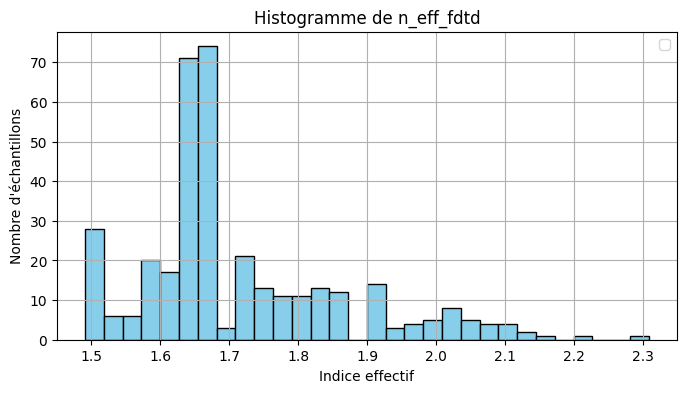

C:\Users\gabriel.legros\AppData\Local\Temp\ipykernel_34048\2049870054.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


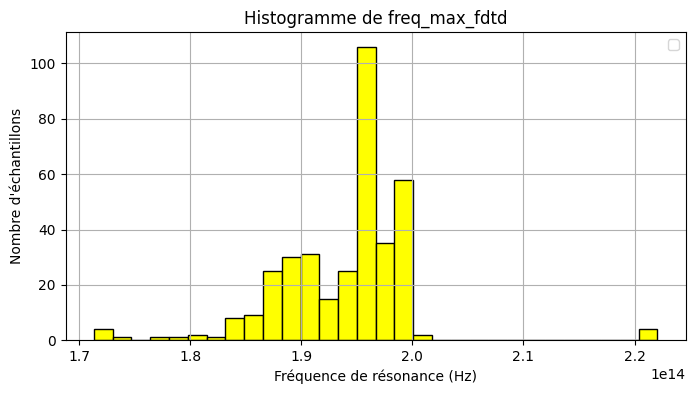

In [22]:
plt.figure(figsize=(8, 4))
plt.hist(n_eff_1pic, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Indice effectif")
plt.ylabel("Nombre d'échantillons")
plt.title("Histogramme de n_eff_fdtd")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(f_1pic, bins=30, color='yellow', edgecolor='black')
plt.xlabel("Fréquence de résonance (Hz)")
plt.ylabel("Nombre d'échantillons")
plt.title("Histogramme de freq_max_fdtd")
plt.grid(True)
plt.legend()
plt.show()

--------------------------------------------------

-----------------------------------

## Evaluation expérimentale aléatoire

### Tirage aléatoire et simulation

In [ ]:
n_values = np.linspace(1.5, 2.4, 100)
f_values = np.linspace(2.0e14, 1.86e14, 100)

f_tol = 1e11 # Hz
n_tol = 1e-2

labels_list = []
n_draw = 100

for _ in range(n_draw):
    n = np.round(np.random.choice(n_values), 2)
    f = int(np.round(np.random.choice(f_values)))
    labels_list.append((f, n))
    
# labels_list contient des tuples (f, n)
labels_cibles = pd.DataFrame(labels_list, columns=["f", "n"])
labels_cibles.to_csv("for_FDTD/labels_cibles.csv", index=False)

In [ ]:
x, y, f, n = [], [], [], []
# Pour chaque combinaison (f, n), on évalue le modèle hybride
for freq, n_eff in labels_list:
    x_1pic_filt_3, y_1pic_filt_3, f_1pic_filt_3, n_eff_1pic_filt_3 = hybrid_model_evaluation(cvae, dataloader_train, device, freq, n_eff, tol_f=f_tol, tol_n=n_tol, n_samples=30000, 
                                                                                scaler_x=scaler_x, scaler_z=scaler_z, saving=False)
    if len(x_1pic_filt_3) > 0:
        x.append(x_1pic_filt_3)
        y.append(y_1pic_filt_3)
        f.append(f_1pic_filt_3)
        n.append(n_eff_1pic_filt_3)

x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)
f = np.concatenate(f, axis=0)
n = np.concatenate(n, axis=0)

df_params = pd.DataFrame(x, columns=["w", "DC", "pitch", "k"])
df_params.to_csv("for_FDTD/for_FDTD_simulation.csv", index=False)

y = y.T  # shape (5000, N)
spec_cols = [f"spectre_{i}" for i in range(y.shape[1])]
df_spectres = pd.DataFrame(y, columns=spec_cols)
df_spectres.to_csv("for_FDTD/model_spectres.csv", index=False)

df_labels = pd.DataFrame({
    "f_max": f,
    "n_eff": n
})
df_labels.to_csv("for_FDTD/model_labels.csv", index=False)

print("Fichiers CSV exportés dans for_FDTD/ : for_FDTD_simulation.csv, model_spectres.csv, model_labels.csv")


Fichiers CSV exportés dans for_FDTD/ : for_FDTD_simulation.csv, model_spectres.csv, model_labels.csv


### Exploitation des résultats FDTD

In [ ]:
# Chargement du fichier CSV dans un numpy array
x_model = np.loadtxt("for_FDTD/for_FDTD_simulation.csv", delimiter=",", skiprows=1)
labels_model = np.loadtxt("for_FDTD/model_labels.csv", delimiter=",", skiprows=1)
x_fdtd = np.array(x_1pic)   # voir Vérification expérimentale

print("Shape du numpy array x_model :", x_model.shape)
print("Shape du numpy array labels_model :", labels_model.shape)    
print("Shape de x_fdtd :" , x_fdtd.shape)
print("============================================================")
print(x_model[:5])
print(x_fdtd[:5])

Shape du numpy array x_model : (562, 4)
Shape du numpy array labels_model : (562, 2)
Shape de x_fdtd : (358, 4)


In [ ]:
# Extraction des valeurs générées par le modèle ayant un résultat FDTD
# ============================================================
fdtd_keys = x_fdtd[:, 3]  # On extrait les valeurs uniques de la dernière colonne de x_fdtd

# On filtre x_model et labels_model en ne gardant que ceux dont le 4e paramètre est dans fdtd_keys
mask = np.isin(x_model[:, 3], fdtd_keys)

# Filtrage
x_model_filtered = x_model[mask]
labels_model_filtered = labels_model[mask]

print(x_model_filtered.shape)
print(labels_model_filtered.shape)

In [178]:
# Clés de tri : les valeurs de la 4ᵉ colonne (indice 3)
model_keys = x_model_filtered[:, 3]

# On suppose que f_1pic et n_eff_1pic sont alignés avec x_fdtd
fdtd_keys = x_fdtd[:, 3]
fdtd_dict = {val: row for val, row in zip(fdtd_keys, x_fdtd)}
f_dict = {val: f for val, f in zip(fdtd_keys, f_1pic)}
n_dict = {val: n for val, n in zip(fdtd_keys, n_eff_1pic)}

# Tri dans l’ordre de x_model_filtered
x_fdtd_sorted = []
f_1pic_sorted = []
n_eff_1pic_sorted = []

for key in model_keys:
    x_fdtd_sorted.append(fdtd_dict[key])
    f_1pic_sorted.append(f_dict[key])
    n_eff_1pic_sorted.append(n_dict[key])

# Convertir en np.array si besoin
x_fdtd_sorted = np.array(x_fdtd_sorted)
f_1pic_sorted = np.array(f_1pic_sorted)
n_eff_1pic_sorted = np.array(n_eff_1pic_sorted)


In [179]:
print(x_model_filtered[:5])
print(x_fdtd_sorted[:5])

[[4.9579352e+02 5.8424443e-01 3.1751132e+02 6.7725385e+06]
 [4.5142734e+02 6.3821405e-01 3.5844763e+02 6.7742575e+06]
 [4.3039610e+02 6.7486010e-01 3.6239800e+02 6.7752510e+06]
 [4.3471725e+02 6.6265110e-01 3.7593480e+02 6.7724800e+06]
 [4.4196973e+02 6.4989910e-01 3.7786475e+02 6.7739405e+06]]
[[4.9579401e+02 5.7999998e-01 3.1751099e+02 6.7725385e+06]
 [4.5142700e+02 6.3999999e-01 3.5844800e+02 6.7742575e+06]
 [4.3039600e+02 6.7000002e-01 3.6239801e+02 6.7752510e+06]
 [4.3471701e+02 6.6000003e-01 3.7593500e+02 6.7724800e+06]
 [4.4197000e+02 6.4999998e-01 3.7786499e+02 6.7739405e+06]]


In [180]:
labels_fdtd = np.column_stack((f_1pic_sorted, n_eff_1pic_sorted))

In [ ]:
print(labels_model_filtered[:20])
print(labels_fdtd[:20])

### Performances

In [182]:
f_pred, n_pred = labels_model_filtered[:, 0], labels_model_filtered[:, 1]
f_ref, n_ref = labels_fdtd[:, 0], labels_fdtd[:, 1]

In [104]:
# Erreurs absolues
err_f_abs = np.abs(f_pred - f_ref)
err_n_abs = np.abs(n_pred - n_ref)

# Erreurs relatives (ajout d'un epsilon pour éviter la division par 0)
eps = 1e-12
err_f_rel = err_f_abs / (np.abs(f_ref) + eps)
err_n_rel = err_n_abs / (np.abs(n_ref) + eps)

# Statistiques
print("Erreur fréquence (Hz) : moyenne =", np.mean(err_f_abs), ", min =", np.min(err_f_abs))
print("Erreur indice : moyenne =", np.mean(err_n_abs), ", min =", np.min(err_n_abs))
print("-------------------------------------------------------------")
print("Erreur relative fréquence : moyenne =", np.mean(err_f_rel))
print("Erreur relative indice : moyenne =", np.mean(err_n_rel))

Erreur fréquence (Hz) : moyenne = 1491067186459.7483 , min = 0.0
Erreur indice : moyenne = 0.01409763021958462 , min = 0.0
-------------------------------------------------------------
Erreur relative fréquence : moyenne = 0.0077274086346844064
Erreur relative indice : moyenne = 0.007793129432465189


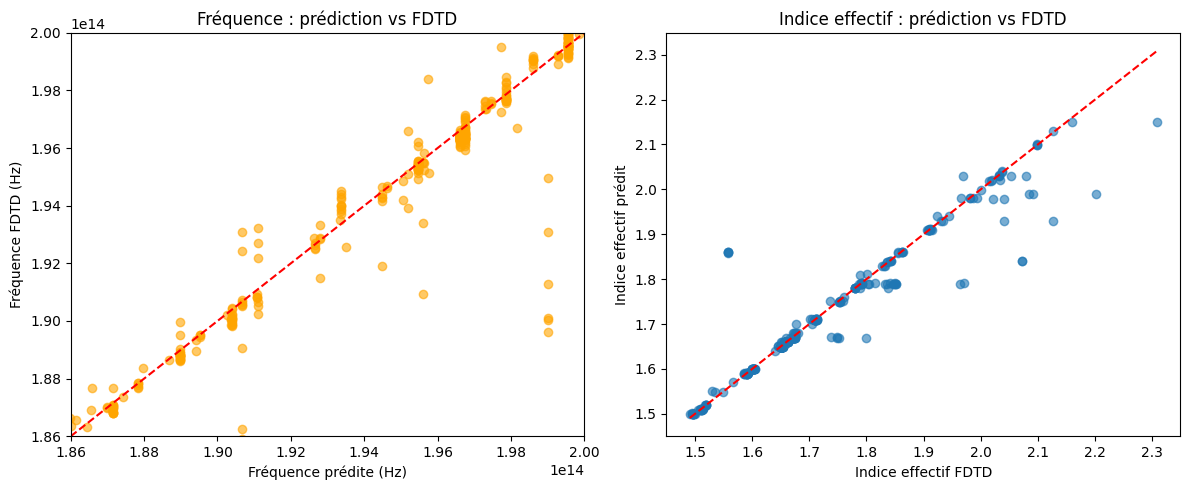

In [122]:
# a. Nuage de points prédiction vs simulation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(f_pred, f_ref, alpha=0.6, color='orange')
plt.plot([f_ref.min(), f_ref.max()], [f_ref.min(), f_ref.max()], 'r--')
plt.xlabel("Fréquence prédite (Hz)")
plt.ylabel("Fréquence FDTD (Hz)")
plt.ylim(1.86e14, 2.0e14)
plt.xlim(1.86e14, 2.0e14)
plt.title("Fréquence : prédiction vs FDTD")

plt.subplot(1, 2, 2)
plt.scatter(n_ref, n_pred, alpha=0.6)
plt.plot([n_ref.min(), n_ref.max()], [n_ref.min(), n_ref.max()], 'r--')
plt.xlabel("Indice effectif FDTD")
plt.ylabel("Indice effectif prédit")
plt.title("Indice effectif : prédiction vs FDTD")

plt.tight_layout()
plt.show()

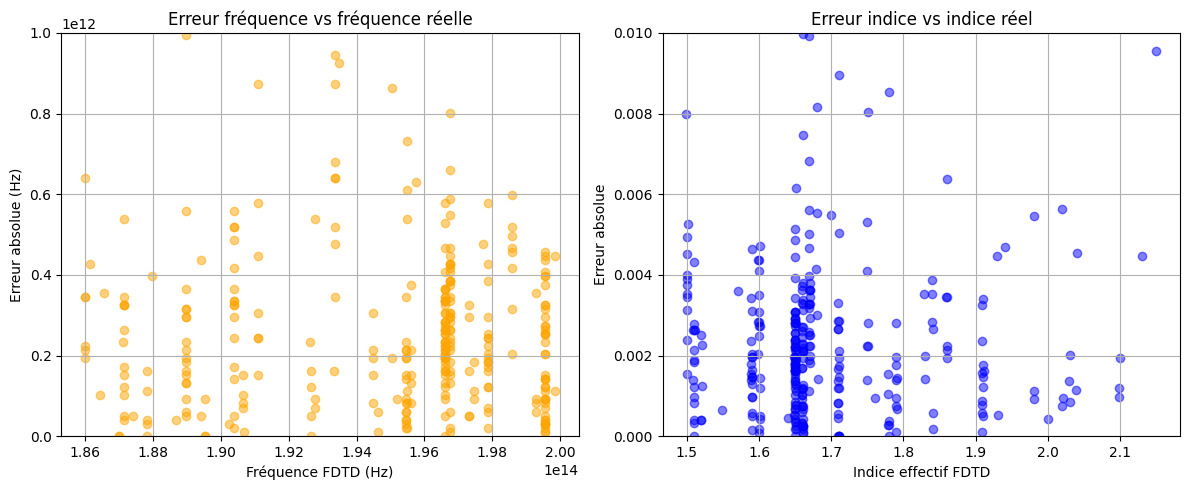

In [128]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(f_pred, err_f_abs, alpha=0.5, color='orange')
plt.title("Erreur fréquence vs fréquence réelle")
plt.xlabel("Fréquence FDTD (Hz)")
plt.ylabel("Erreur absolue (Hz)")

plt.ylim(0, 1e12)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(n_pred, err_n_abs, alpha=0.5, color='blue')
plt.title("Erreur indice vs indice réel")
plt.xlabel("Indice effectif FDTD")
plt.ylabel("Erreur absolue")
plt.ylim(0, 0.01)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Liste cible
indices_cibles = [
    1.57, 1.83, 1.95, 1.71, 2.03, 2.36, 1.96, 2.02, 1.60, 1.51,
    2.00, 2.03, 1.51, 1.98, 2.36, 1.50, 1.51, 1.89, 1.78, 1.78,
    1.99, 2.00, 1.84, 2.12, 2.13, 1.59, 2.37, 2.03, 2.22, 1.52,
    2.03, 1.66, 2.10, 1.67, 2.14, 1.79, 1.85, 1.50, 2.33, 2.30,
    1.70, 2.35, 2.39, 1.64, 2.04, 1.50, 1.60, 1.83, 1.57, 1.66,
    2.22, 1.67, 1.98, 1.71, 2.15, 1.84, 2.39, 2.39, 2.34, 2.24,
    1.98, 2.22, 1.86, 1.79, 1.79, 1.68, 1.67, 1.55, 1.65, 1.93,
    2.03, 1.69, 1.84, 1.98, 1.74, 2.38, 1.76, 1.75, 2.37, 2.05,
    1.66, 1.81, 1.94, 1.89, 1.76, 1.91, 2.39, 1.71, 1.91, 2.35,
    2.04, 2.06, 1.78, 1.79, 1.65, 2.35, 2.02, 1.91, 1.78, 2.27
]


# Tableau des indices simulés (FDTD)
n_eff_1pic = np.array(n_eff_1pic)  # Assure que c'est bien un numpy array

# Résultat : (valeur cible, valeur trouvée, erreur)
resultats = []

for cible in indices_cibles:
    # Calcul des distances
    distances = np.abs(n_eff_1pic - cible)
    min_idx = np.argmin(distances)
    min_distance = distances[min_idx]
    
    if min_distance <= 1e-2:
        valeur_proche = n_eff_1pic[min_idx]
        erreur = abs(valeur_proche - cible)
        resultats.append((cible, valeur_proche, erreur))
    else:
        resultats.append((cible, None, None))

# Conversion en tableau numpy pour affichage ou traitement
resultats_array = np.array(resultats, dtype=object)

# Affichage propre
import pandas as pd
df = pd.DataFrame(resultats_array, columns=["Cible", "Trouvée", "Erreur"])

print(df.to_string(index=False))


In [213]:
# Récupérer les valeurs de "Cible" où "Trouvée" est None
missing_n = df.loc[df["Trouvée"].isna(), "Cible"].to_numpy()
print(missing_n)

[2.36 2.36 1.89 2.37 2.22 2.14 2.33 2.35 2.39 2.22 2.15 2.39 2.39 2.34
 2.24 2.22 1.69 2.38 2.37 1.89 2.39 2.35 2.35 2.27]


In [210]:
# Calcul du pourcentage de None dans la colonne "Trouvée"
total = len(df)
nb_none = df['Trouvée'].isna().sum()  # .isna() détecte les None/NaN

pourcentage_trouve = (1-(nb_none / total)) * 100
print(f"Pourcentage de d'indice dans 'Trouvée' : {pourcentage_trouve:.2f}%")

Pourcentage de d'indice dans 'Trouvée' : 76.00%


In [188]:
df.to_csv("correspondance_indices_cibles.csv", index=False)

In [211]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# On suppose que tu as un DataFrame df avec les colonnes "Cible", "Trouvée", "Erreur"
# Filtrage des lignes valides (erreur non nulle)
df_valide = df.dropna()


In [212]:
# Moyenne des erreurs (sur les lignes où "Erreur" n'est pas None/NaN)
moyenne_erreur = df_valide["Erreur"].mean()
print("Moyenne des erreurs :", moyenne_erreur)

Moyenne des erreurs : 0.0012679626186698168


C:\Users\gabriel.legros\AppData\Local\Temp\ipykernel_11760\1410301369.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([df_valide["Cible"].min(), df_valide["Cible"].max()],
C:\Users\gabriel.legros\AppData\Local\Temp\ipykernel_11760\1410301369.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


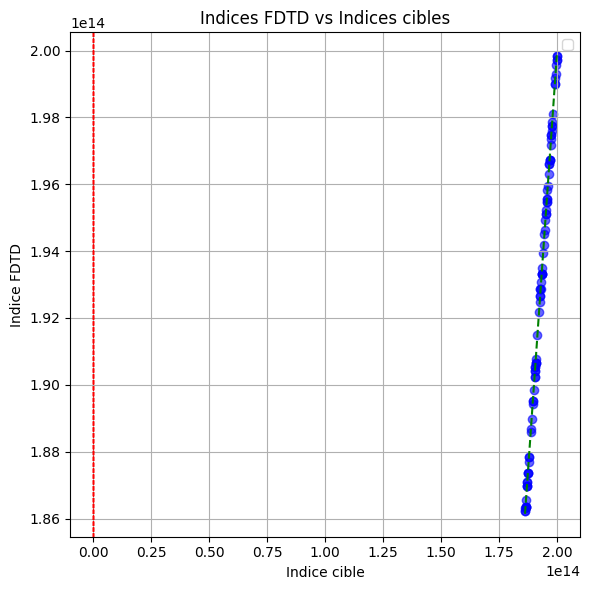

In [494]:
plt.figure(figsize=(6, 6))
plt.scatter(df_valide["Cible"], df_valide["Trouvée"], alpha=0.6, color='blue')
plt.plot([df_valide["Cible"].min(), df_valide["Cible"].max()],
         [df_valide["Cible"].min(), df_valide["Cible"].max()],
         'r--', color='green')
plt.xlabel("Indice cible")
plt.ylabel("Indice FDTD")
plt.title("Indices FDTD vs Indices cibles")
plt.grid(True)
plt.legend()
plt.tight_layout()
# Liste des indices cibles (n)

# Ajout de lignes verticales pointillées rouges
for n in missing_n:
    plt.axvline(x=n, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

plt.show()


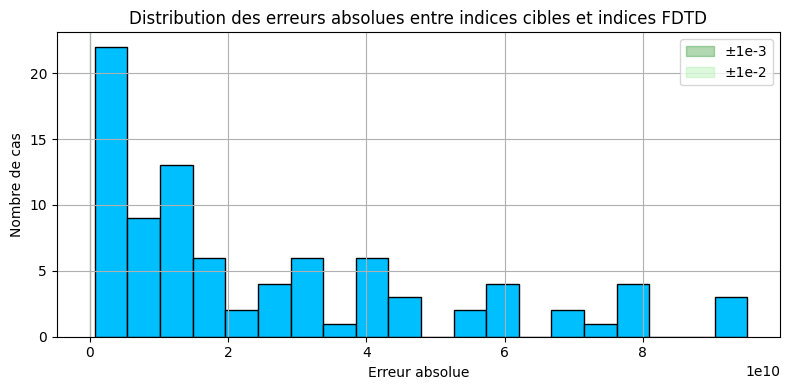

In [493]:
plt.figure(figsize=(8, 4))
plt.hist(df_valide["Erreur"], bins=20, color='#00BFFF', edgecolor='black')
plt.xlabel("Erreur absolue")
plt.ylabel("Nombre de cas")
plt.title("Distribution des erreurs absolues entre indices cibles et indices FDTD")
plt.grid(True)
plt.tight_layout()
# Plage ±1e-3 autour de 1.9
plt.axvspan(0, 0 + 1e-3, color='green', alpha=0.3, label='±1e-3')
plt.axvspan(0.001, 0.008, color='lightgreen', alpha=0.3, label='±1e-2')
# Plage ±1e-2 autour de 1.9
#plt.axvspan(1.9 - 1e-2, 1.9 + 1e-2, color='lightgreen', alpha=0.3, label='±1e-2')
plt.legend()

plt.show()


In [487]:
freq_cibles = [
    191373737373737, 186424242424242, 193919191919192, 188969696969697,
    195616161616162, 187696969696970, 191373737373737, 192787878787879,
    194626262626263, 199717171717172, 188686868686869, 199858585858586,
    187131313131313, 187838383838384, 186424242424242, 197454545454545,
    192646464646465, 187414141414141, 190242424242424, 190525252525253,
    189535353535354, 197737373737374, 196747474747475, 186282828282828,
    187979797979798, 197878787878788, 189818181818182, 190242424242424,
    186989898989899, 197313131313131, 195050505050505, 187414141414141,
    197454545454545, 186565656565657, 192787878787879, 194484848484848,
    188545454545455, 198585858585859, 192080808080808, 193070707070707,
    195757575757576, 194202020202020, 199151515151515, 187414141414141,
    199858585858586, 193353535353535, 190383838383838, 195616161616162,
    186141414141414, 193353535353535, 199717171717172, 196747474747475,
    195474747474747, 189535353535354, 195050505050505, 188262626262626,
    187555555555556, 196606060606061, 197595959595960, 190808080808081,
    195191919191919, 191515151515152, 186000000000000, 190525252525253,
    198161616161616, 193353535353535, 199010101010101, 190666666666667,
    195474747474747, 189393939393939, 187979797979798, 195898989898990,
    192929292929293, 199010101010101, 196323232323232, 197171717171717,
    186424242424242, 191090909090909, 190383838383838, 193353535353535,
    199575757575758, 191090909090909, 197737373737374, 187131313131313,
    186989898989899, 199292929292929, 194909090909091, 186989898989899,
    192646464646465, 186141414141414, 186424242424242, 188121212121212,
    187838383838384, 190666666666667, 196606060606061, 192505050505050,
    190666666666667, 196747474747475, 193494949494950, 196888888888889
]


In [ ]:
# Tableau des indices simulés (FDTD)
f_1pic = np.array(f_1pic)  # Assure que c'est bien un numpy array

# Résultat : (valeur cible, valeur trouvée, erreur)
resultats = []

for cible in freq_cibles:
    # Calcul des distances
    distances = np.abs(f_1pic - cible)
    min_idx = np.argmin(distances)
    min_distance = distances[min_idx]
    
    if min_distance <= 1e11:
        valeur_proche = f_1pic[min_idx]
        valeur_n = n_eff_1pic[min_idx]
        erreur = abs(valeur_proche - cible)
        resultats.append((cible, (valeur_proche, valeur_n), erreur))
    else:
        resultats.append((cible, None, None))

# Conversion en tableau numpy pour affichage ou traitement
resultats_array = np.array(resultats, dtype=object)

# Affichage propre
import pandas as pd
df = pd.DataFrame(resultats_array, columns=["Cible", "Trouvée", "Erreur"])

print(df.to_string(index=False))

In [489]:
# Calcul de la différence absolue entre la 2e valeur du tuple "Trouvée" et indices_cibles, en évitant les None

# On suppose que df, indices_cibles existent déjà
abs_diffs = []
for idx, row in df.iterrows():
    trouvée = row["Trouvée"]
    if trouvée is not None:
        n_trouve = trouvée[1]  # 2e valeur du tuple
        n_cible = indices_cibles[idx]
        abs_diffs.append(abs(n_trouve - n_cible))

# Moyenne des différences absolues
if abs_diffs:
    print("Moyenne des différences absolues :", np.mean(abs_diffs))
else:
    print("Aucune valeur trouvée pour le calcul de la moyenne.")

Moyenne des différences absolues : 0.25422858781131136


In [490]:
# Récupérer les valeurs de "Cible" où "Trouvée" est None
missing_f = df.loc[df["Trouvée"].isna(), "Cible"].to_numpy()
print(missing_f)

[191373737373737 191373737373737 187979797979798 198585858585859
 188262626262626 187555555555556 186000000000000 187979797979798
 191090909090909 191090909090909 188121212121212]


In [492]:
# Calcul du pourcentage de None dans la colonne "Trouvée"
total = len(df)
nb_none = df['Trouvée'].isna().sum()  # .isna() détecte les None/NaN

pourcentage_trouve = (1- nb_none / total) * 100
print(f"Pourcentage de de freq dans 'Trouvée' : {pourcentage_trouve:.2f}%")

Pourcentage de de freq dans 'Trouvée' : 89.00%


In [228]:
# On suppose que tu as un DataFrame df avec les colonnes "Cible", "Trouvée", "Erreur"
# Filtrage des lignes valides (erreur non nulle)
df_valide = df.dropna()

C:\Users\gabriel.legros\AppData\Local\Temp\ipykernel_11760\1037671918.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([df_valide["Cible"].min(), df_valide["Cible"].max()],
C:\Users\gabriel.legros\AppData\Local\Temp\ipykernel_11760\1037671918.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


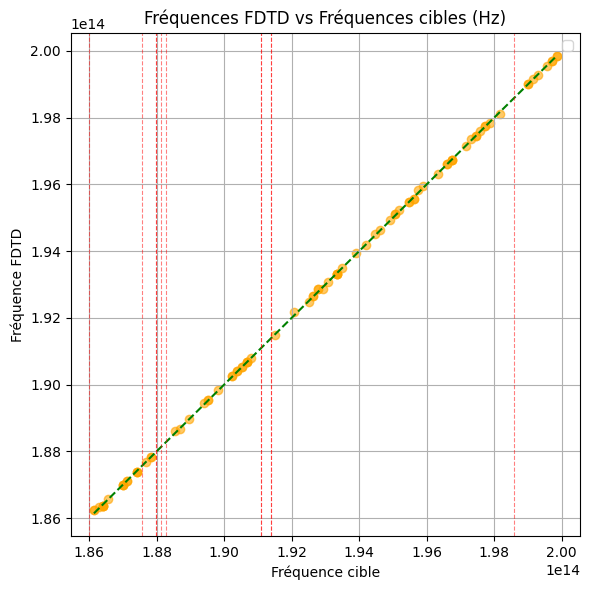

In [232]:
plt.figure(figsize=(6, 6))
plt.scatter(df_valide["Cible"], df_valide["Trouvée"], alpha=0.6, color='orange')
plt.plot([df_valide["Cible"].min(), df_valide["Cible"].max()],
         [df_valide["Cible"].min(), df_valide["Cible"].max()],
         'r--', color='green')
plt.xlabel("Fréquence cible")
plt.ylabel("Fréquence FDTD")
plt.title("Fréquences FDTD vs Fréquences cibles (Hz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
# Liste des indices cibles (n)

# Ajout de lignes verticales pointillées rouges
for n in missing_f:
    plt.axvline(x=n, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

plt.show()


### Analyse par couble labels

In [458]:
# Liste cible
indices_cibles = [
    1.57, 1.83, 1.95, 1.71, 2.03, 2.36, 1.96, 2.02, 1.60, 1.51,
    2.00, 2.03, 1.51, 1.98, 2.36, 1.50, 1.51, 1.89, 1.78, 1.78,
    1.99, 2.00, 1.84, 2.12, 2.13, 1.59, 2.37, 2.03, 2.22, 1.52,
    2.03, 1.66, 2.10, 1.67, 2.14, 1.79, 1.85, 1.50, 2.33, 2.30,
    1.70, 2.35, 2.39, 1.64, 2.04, 1.50, 1.60, 1.83, 1.57, 1.66,
    2.22, 1.67, 1.98, 1.71, 2.15, 1.84, 2.39, 2.39, 2.34, 2.24,
    1.98, 2.22, 1.86, 1.79, 1.79, 1.68, 1.67, 1.55, 1.65, 1.93,
    2.03, 1.69, 1.84, 1.98, 1.74, 2.38, 1.76, 1.75, 2.37, 2.05,
    1.66, 1.81, 1.94, 1.89, 1.76, 1.91, 2.39, 1.71, 1.91, 2.35,
    2.04, 2.06, 1.78, 1.79, 1.65, 2.35, 2.02, 1.91, 1.78, 2.27
]
freq_cibles = [
    191373737373737, 186424242424242, 193919191919192, 188969696969697,
    195616161616162, 187696969696970, 191373737373737, 192787878787879,
    194626262626263, 199717171717172, 188686868686869, 199858585858586,
    187131313131313, 187838383838384, 186424242424242, 197454545454545,
    192646464646465, 187414141414141, 190242424242424, 190525252525253,
    189535353535354, 197737373737374, 196747474747475, 186282828282828,
    187979797979798, 197878787878788, 189818181818182, 190242424242424,
    186989898989899, 197313131313131, 195050505050505, 187414141414141,
    197454545454545, 186565656565657, 192787878787879, 194484848484848,
    188545454545455, 198585858585859, 192080808080808, 193070707070707,
    195757575757576, 194202020202020, 199151515151515, 187414141414141,
    199858585858586, 193353535353535, 190383838383838, 195616161616162,
    186141414141414, 193353535353535, 199717171717172, 196747474747475,
    195474747474747, 189535353535354, 195050505050505, 188262626262626,
    187555555555556, 196606060606061, 197595959595960, 190808080808081,
    195191919191919, 191515151515152, 186000000000000, 190525252525253,
    198161616161616, 193353535353535, 199010101010101, 190666666666667,
    195474747474747, 189393939393939, 187979797979798, 195898989898990,
    192929292929293, 199010101010101, 196323232323232, 197171717171717,
    186424242424242, 191090909090909, 190383838383838, 193353535353535,
    199575757575758, 191090909090909, 197737373737374, 187131313131313,
    186989898989899, 199292929292929, 194909090909091, 186989898989899,
    192646464646465, 186141414141414, 186424242424242, 188121212121212,
    187838383838384, 190666666666667, 196606060606061, 192505050505050,
    190666666666667, 196747474747475, 193494949494950, 196888888888889
]

In [ ]:
# Pour obtenir un array de shape
freq_cibles_np = np.array(freq_cibles)
indices_cibles_np = np.array(indices_cibles)
array_labels = np.column_stack([freq_cibles_np, indices_cibles_np])  # shape 
print(array_labels.shape)  
print(array_labels)

In [ ]:
freq_fdtd_np = np.array(f_1pic)
indices_fdtd_np = np.array(n_eff_1pic)
array_labels_fdtd = np.column_stack([freq_fdtd_np, indices_fdtd_np])  # shape 
print(array_labels_fdtd.shape)  
print(array_labels_fdtd)

In [ ]:
import numpy as np
from scipy.spatial import cKDTree
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
array_labels_scaled = scaler.fit_transform(array_labels)
array_labels_fdtd_scaled = scaler.transform(array_labels_fdtd)

kd_tree = cKDTree(array_labels_fdtd_scaled)
distances, idxs = kd_tree.query(array_labels_scaled, k=1)

closest_scaled = array_labels_fdtd_scaled[idxs]
# Pour repasser de l'espace standardisé à l'espace original :
closest_original = scaler.inverse_transform(closest_scaled)
errors_original = np.abs(closest_original - array_labels)

# Exemple d'affichage pour les 5 premiers :
for i in range(20):
    print(f"Target     : {array_labels[i]}")
    print(f"Closest    : {closest_original[i]}")
    print(f"Abs errors : f={errors_original[i,0]:.3e}, n={errors_original[i,1]:.3f}")
    print("-" * 40)

In [462]:
mean_error_f = np.mean(errors_original[:, 0])  # moyenne des erreurs sur f
mean_error_n = np.mean(errors_original[:, 1])  # moyenne des erreurs sur n

print(f"Erreur moyenne sur f : {mean_error_f:.3e}")
print(f"Erreur moyenne sur n : {mean_error_n:.3f}")

Erreur moyenne sur f : 4.799e+11
Erreur moyenne sur n : 0.051


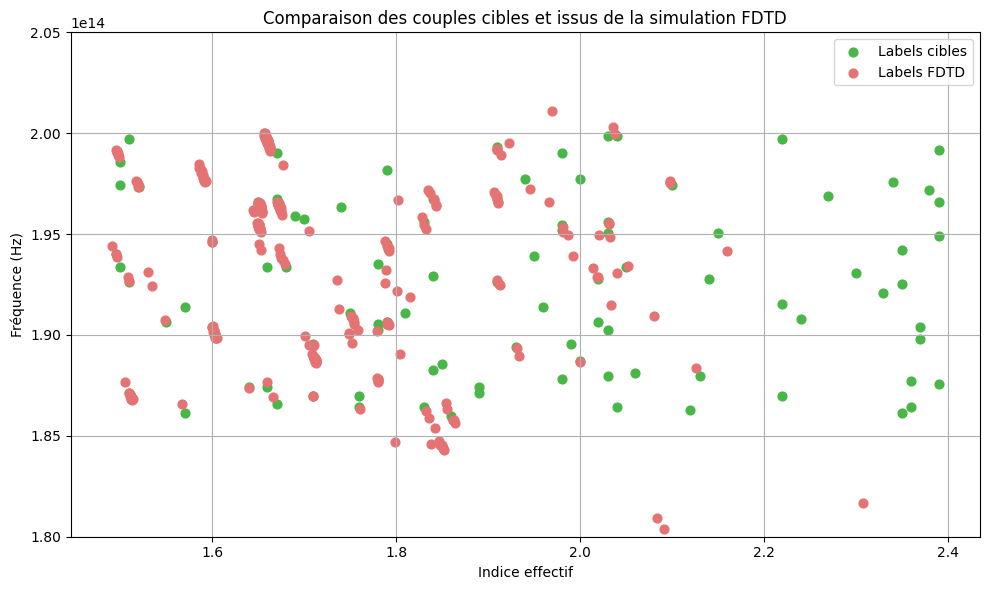

In [476]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple (à remplacer par tes vrais tableaux)
# array_labels = np.array([[f1, n1], [f2, n2], ...])
# array_labels_fdtd = np.array([[f1_fdtd, n1_fdtd], [f2_fdtd, n2_fdtd], ...])

# Extraction des composantes
n_labels = array_labels[:, 1]
f_labels = array_labels[:, 0]

n_fdtd = array_labels_fdtd[:, 1]
f_fdtd = array_labels_fdtd[:, 0]

# Tracé
plt.figure(figsize=(10, 6))
plt.scatter(n_labels, f_labels, color='#48B748', label='Labels cibles', s=40)
plt.scatter(n_fdtd, f_fdtd, color='#E67373', label='Labels FDTD', s=40)


plt.xlabel("Indice effectif")
plt.ylabel("Fréquence (Hz)")
plt.title("Comparaison des couples cibles et issus de la simulation FDTD")
plt.legend()
plt.grid(True)
plt.ylim(1.8e14, 2.05e14)  # Ajuster selon les valeurs de fréquence
plt.tight_layout()
plt.show()
